# Advanced Line Findings Project
## Imports

In [ ]:
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from   lanesdetectionlib    import *
%matplotlib inline


## Camera calibration
### Attributes

In [3]:
CHESSBOARD_IMAGES_PATH = "camera_cal\\calibration*.jpg"
CALIBRATION_RESULT_PATH = "camera_calibration.p"
NX = 9   # chessboard inside borders on x axis
NY = 6   # chessboard inside borders on y axis


# ATTRIBUTES FOR A TEST IMAGE  

TEST_IMAGE_PATH = "camera_cal\\calibration8.jpg"
TEST_IMAGE_UNDISTORTED_PATH = "camera_cal\\calibration8_undistorted.jpg"

### Helper functions

In [4]:
# HELPER FUNCTIONS FOR CAMERA CALIBRATION


"""
This function takes as an argument a path containing several photos of a chessboard named in a regular way.
'nx' and 'ny' are the number of horizontal and vertical inner corners inside the chessboard. 
It draws the corners over the original images and prints using matplotlib.
It then a tuple containing the a list of the position for each corner and a list of a (numpy) matrix initialized with zeros
of the same dimensions of the chessboard.
"""
def get_img_obj_points(path, nx, ny):
    # Read in and make a list of calibration images
    imgpoints, objpoints = [], []
    # glob allows us to read in files with consistent file names
    # e.g. calibration-1.jpg, calibration-2.jpg...
    images = glob.glob(path)

    # Generate object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) # x, y coordinates

    for fname in images:
        img = cv2.imread(fname) # Read in image in BGR
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None) # Find the chessboard corners
        # If found, update array points draw corners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret) 
            plt.imshow(img)
    
    return imgpoints, objpoints

"""
Given a list of points of the inner corners of the chessboard, a list of objpoints (needed by OpenCV, see the function above)
and 'mtx' (a perspective conversion matrix) and 'dist' (both these parameters are returned by OpenCV.calibrateCamera()
it stores the results of the calibration in a dictionary and then in a file
"""
def store_calibration_results(imgpoints,objpoints,mtx,dist):            # Store the calibration results
    calibration_results = {}
    calibration_results["imgpoints"] = imgpoints
    calibration_results["objpoints"] = objpoints
    calibration_results["mtx"] = mtx
    calibration_results["dist"] = dist
    pickle.dump(calibration_results, open(CALIBRATION_RESULT_PATH, "wb" ))

    
"""
It shows two images on close to the other
"""    
def show_distorted_and_undistorted_image(dist,undist):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(dist)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(undist)
    ax2.set_title('Undistorted Image', fontsize=30)
    


""" Calculates the information necessary to calibrate a camera and stores it in a pickle. """
def calibrate_camera():
    imgpoints, objpoints = get_img_obj_points(CHESSBOARD_IMAGES_PATH,NX,NY)
    test_img = cv2.imread(TEST_IMAGE_PATH)
    img_size = (test_img.shape[1], test_img.shape[0])
    # CV2 Camera calibration, we get here the necessary parameters for undistortion
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    store_calibration_results(imgpoints,objpoints,mtx,dist)

""" Retrieve the previously stored calibration results"""
def load_calibration_result():
    with open(CALIBRATION_RESULT_PATH, mode='rb') as f:
        camera_calib = pickle.load(f)
        mtx = camera_calib["mtx"]
        dist = camera_calib["dist"]
        return mtx, dist


### One time - Calibration

In [ ]:
calibrate_camera()
print("Camera calibration completed.")

### Restore calibration result and test it

In [ ]:
mtx, dist = load_calibration_result()   # Load result of previous calibration

# Test the calibration on a chessboard image
test_img = cv2.imread(TEST_IMAGE_PATH)
test_img_shp = test_img.shape
imshape = test_img.shape
img_size = (test_img.shape[1], test_img.shape[0])
test_img_undst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite(TEST_IMAGE_UNDISTORTED_PATH,test_img_undst)
show_distorted_and_undistorted_image(test_img[...,::-1],test_img_undst[...,::-1])

In [6]:

def load_calibration_result():
    with open(CALIBRATION_RESULT_PATH, mode='rb') as f:
        camera_calib = pickle.load(f)
        mtx = camera_calib["mtx"]
        dist = camera_calib["dist"]
        return mtx, dist


mtx2, dist2 = load_calibration_result()   # Load result of previous calibration

# Test the calibration on a chessboard image
test_img2 = cv2.imread("test_images\\test1.jpg")
test_img_shp2 = test_img2.shape
imshape2 = test_img2.shape
img_size2 = (test_img2.shape[1], test_img2.shape[0])
test_img_undst2 = cv2.undistort(test_img2, mtx2, dist2, None, mtx2)
cv2.imwrite("test_images\\test1_u.jpg",test_img_undst2)

True

## Lanes recognition
### Pipeline attributes

In [6]:
# ATTRIBUTES FOR TRESHOLDING

### Credits to 
### https://github.com/jessicayung/self-driving-car-nd/blob/master/p4-advanced-lane-lines/p4-advanced-lane-lines.ipynb
### and https://github.com/wonjunee/Advanced-Lane-Finding/blob/master/Advanced-Lane-Finding-Submission.ipynb



S_CH_TRESH =  (205,255)    # S channel treshold    (205,255)
X_SOBEL_TRESH = (10, 255)   # X sobel treshold
MAG_TRESH = (40, 255)        # magnitude (of the gradient vector) treshold
DIR_TRESH = (.65, 1.05)      # Direction (of the gradient vector) treshold
SOBEL_K_SIZE = 7             # Must be odd since we want to consider a symmetric area around the considered pixel
GAUSSIAN_BLUR_K_SIZE = 5 


# Defining vertices for marked area
vertices = np.array([[(100, imshape[0]), (610, 410), (680, 410), \
                          (imshape[1]-20, imshape[0]), (1150, imshape[0]), \
                          (700,480), (650,480), (310, imshape[0])]], dtype=np.int32)
    

### WARPING ATTRIBUTES
src = np.float32([[150+430,460],[1150-440,460],[1150,720],[150,720]])
dst = np.float32([[200, 0], 
                      [img_size[0]-200, 0], 
                      [img_size[0]-200, img_size[1]], 
                      [200, img_size[1]]])

### Helper functions

In [7]:
class Line():
    def __init__(self):
        self.detected = False                    # was the line detected in the last iteration?
        self.recent_xfitted = []                 # x values of the last n fits of the line   
        self.bestx = None                        # average x values of the fitted line over the last n iterations
        self.best_fit = None                     # polynomial coefficients averaged over the last n iterations           
        self.current_fit = [np.array([False])]   # polynomial coefficients for the most recent fit
        self.radius_of_curvature = None          # radius of curvature of the line in some units
        self.line_base_pos = None                # distance in meters of vehicle center from the line
        self.diffs = np.array([0,0,0], dtype='float') # difference in fit coefficients between last and new fits
        self.allx = None                              # x values for detected line pixels
        self.ally = None                              # y values for detected line pixels
        self.windows = np.ones((3,12))*-1             # x values in windows
        
"""
This function given a np array of x coordinates representing a lane line (fitx)
return the radius of curvature of that line. This is done
assuming a (700,720) image and a view of 30 meters in the vertical direction and 3.7 meters in horizontal direction 
"""
def find_curvature(fitx):
    yvals = np.linspace(0, 100, num=101)*7.2                    # to cover same y-range as image
    y_eval = np.max(yvals)  # y_eval is the point where radius of curvature is evalueted. We chose the bottom of the image
    
    # Define conversions in x and y from pixels space to meters.
    # Roughly the image has a view of 30 meters in front of the car and 3.7 meters in the horizontal direction
    ym_per_pix = 30/720          # meters per pixel in y dimension
    xm_per_pix = 3.7/700         # meters per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

"""
This function given a np array of the points representing the lines, selects the points close 
to the bottom of the image and among them it takes the leftmost and rightmost point. 
It then uses this information to compute the middle of the lane and the difference between it and the middle of the image
"""
def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    position = test_img_shp[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    xm_per_pix = 3.7/700                                 # meters per pixel in x dimension    
    return (position - center)*xm_per_pix



"""
This functions selects a region of between 2 vertical boundaries (y_top and y_bottom) of an image and 
for each x coordinate computes the vertical sum of the values in that region. 
It then checks which is the maximum value in a horizontal range of type (x_left, x_right) and returns the index 
correspondant to the maximum. 
"""
def histogram_method(image, y_top, y_bottom, x_left, x_right):
    histogram = np.sum(image[y_top:y_bottom,:], axis=0)                  # Vertical sum in the range (y_top,y_bottom)
    if len(histogram[int(x_left):int(x_right)])>0:                       # Checks that the x range makes sense
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left   # Take the x position corresponding to the peak
    else:
        return (x_left + x_right) / 2                                   # Return the half point of that range, fallback scenario

    
    
"""
Given 'lane' (instance of the Line class) and a radius of curvature, the x points of a lane and the associated polynomial coefficients
detected in this frame and the returns the x points and coefficients to be used, updating the lane instance, 
with the following logic:
1) If lane was detected in the previous frame: if the radius of curvature differs less then 60% from the previous one
keep the current result, otherwise keep the previous one and update the lane instance
2) If lane was not detected in the previous frame, but in one of the previous ones applies the same logic of point one with a 100% tolerance
3) If lane was not detected in any previous frame, keep the current result as it is
"""    
def check_lane_sanity(lane, curverad, fitx, fit):
    if lane.detected:            # Last time lane was detected, therefore we have the info of the last frame
        # Consider a 60% tolerance between the old and new radius of curvature, to accept the new detection
        if abs((curverad - lane.radius_of_curvature) / lane.radius_of_curvature) < .6:     
            lane.detected = True
            lane.current_fit = fit         # Coefficients for the most recent poly fit
            lane.allx = fitx               # x values for the lane
            lane.radius_of_curvature = curverad 
        else:                              # Use the old detection
            lane.detected = False  
            fitx = lane.allx               # x values for the lane, take the previous one
            fit =  lane.current_fit        # Coefficients taken from the previous poly fit
    else:                   # Last time lane was not detected, therefore we may have the info of the second to last frame
        if lane.radius_of_curvature: 
            # Consider a 100% tolerance between the old and new radius of curvature, to accept the new detection
            if abs((curverad - lane.radius_of_curvature) / lane.radius_of_curvature) < 1:            
                lane.detected = True
                lane.current_fit = fit         # Coefficients for the most recent poly fit
                lane.allx = fitx               # x values for the lane
                lane.radius_of_curvature = curverad 
            else:
                lane.detected = False
                fitx = lane.allx               # x values for the lane, take the previous one
                fit =  lane.current_fit        # Coefficients taken from the previous poly fit
        else:  # No sanity check can be performed
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.radius_of_curvature = curverad
    return fitx, fit



# Since we use a histogram sliding window method to find lanes, leverage on previous info to make the 
# detection more robust: 
# If the difference between the last indexes found and the difference between the indexes of before
def check_histogram_peak_robustness(last, last_minus_1, last_minus_2):
    if abs(((last-last_minus_1)-(last_minus_1-last_minus_2)) / (last_minus_1-last_minus_2)) < .2:
        return last
    else:
        return last_minus_1 + (last_minus_1 - last_minus_2)


"""
Given a bird eye black and white image of lane lines of a street,
and a set of parameters (i.e. the vertical region to be considered->(y_top,y_bottom), 
the x coordinates for the left and right lane center of the last 2 iterations of the histogram method loop
and the x coordinate for center of the lane of this iteration) it uses the histogram method
to detect lane lines and performs a robustness check of the result, using the  check_histogram_peak_robustness() above
Information from a previous frame is not used
"""
def find_lanes_wo_previous(image, y_top, y_bottom, x_left, x_right, x_left_pre, x_right_pre, center_pre):
    # Find the historgram from the image inside the window
    left  = histogram_method(image, y_top, y_bottom, x_left-200, x_left+200)
    right = histogram_method(image, y_top, y_bottom, x_right-200, x_right+200)
    left  = check_histogram_peak_robustness(left, x_left, x_left_pre)
    right = check_histogram_peak_robustness(right, x_right, x_right_pre)
    center = (left + right)/2
    dire = center - center_pre
    return left, right, center_pre, center, dire


'''
left_lane and right_lane  GLOBAL VARIABLES, TO BE FIXED
------
n ---> number of vertical windows used to identify peaks of histograms
x_window-----> will be used as range to consider the original pixels in the binary birdeye image, after every iteration of the histogram method

'''
def find_lanes(n, image, x_window, lanes, lx_lane, ly_lane, rx_lane, ry_lane, window_ind):
    # 'n' windows will be used to identify peaks of histograms
    # Set app. This is used for placeholder.
    app = np.zeros((n+1,2))
    
    app[0], app[1] = [300, 1100] , [300, 1100]                   # These values are considered as a horizontal range to look for left and right lane at the beginning of the computation
    # Set the first left and right values
    left, right = (300, 1100)
    # Set the center
    center = 700
    # Set the previous center
    center_pre = center
    # Set the direction
    dire = 0
    for i in range(n-1):
        y_top, y_bottom = 720-(720//n)*(i+1) , 720-(720//n)*i                     # set Y window
        if (left_lane.detected==False) and (right_lane.detected==False):          # Both lanes were not detected in the previous image
            left, right, center_pre, center, dire = find_lanes_wo_previous(image, y_top, y_bottom, app[i+1,0], app[i+1,1], app[i,0], app[i,1], center)
        else:       # Take the previous detecting 
            left  = left_lane.windows[window_ind, i]      
            right = right_lane.windows[window_ind, i]
        # Make sure the distance between left and right laens are wide enough
        if abs(left-right) > 600:
            
            # Left and right are indices of the deemed position of the lanes
            
            
            # LEFT LANE
            
            # "lanes" contains the indices of the pixels set to 1 in the binary birdeye image
            l_lane_arr = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_bottom) & (lanes[:,0]>=y_top)]
            lx_lane += l_lane_arr[:,1].flatten().tolist()
            ly_lane += l_lane_arr[:,0].flatten().tolist()
            if not math.isnan(np.mean(l_lane_arr[:,1])):
                left_lane.windows[window_ind, i] = np.mean(l_lane_arr[:,1])
                app[i+2,0] = np.mean(l_lane_arr[:,1])
            else:
                app[i+2,0] = app[i+1,0] + dire
                left_lane.windows[window_ind, i] = app[i+2,0]
                
            # RIGHT LANE
            
            r_lane_arr = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_bottom) & (lanes[:,0]>=y_top)]
            rx_lane += r_lane_arr[:,1].flatten().tolist()
            ry_lane += r_lane_arr[:,0].flatten().tolist()
            if not math.isnan(np.mean(r_lane_arr[:,1])):
                right_lane.windows[window_ind, i] = np.mean(r_lane_arr[:,1])
                app[i+2,1] = np.mean(r_lane_arr[:,1])
            else:
                app[i+2,1] = app[i+1,1] + dire
                right_lane.windows[window_ind, i] = app[i+2,1]
    return lx_lane, ly_lane, rx_lane, ry_lane



"""
Given x_lane containing x points and y_lane containing y_points, 
it returns:
lane_fit ---> coefficients of the most fitting quadratic polinomial 
lane_fitx ---> x points for the 100 y equally spaced values
"""
def find_poly_coeff_and_values(x_lane,y_lane):
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    lane_fit = np.polyfit(y_lane, x_lane, 2)
    lane_fitx = lane_fit[0]*yvals**2 + lane_fit[1]*yvals + lane_fit[2]
    return lane_fit, lane_fitx


# Function to find the fitting lines from the warped image
def fit_lanes(image):
    # find the coordinates from the image
    lanes = np.argwhere(image)    # takes the indices of the pixels set to 1
    # Coordinates for left lane
    lx_lane, ly_lane, rx_lane, ry_lane = [], [], [], []
    # Curving left or right - -1: left 1: right
    curve = 0
    # Set left and right as None
    left , right = None, None
    # Find lanes from three repeated procedures with different window values
    lx_lane, ly_lane, rx_lane, ry_lane = find_lanes(4, image, 25, lanes, lx_lane, ly_lane, rx_lane, ry_lane, 0)
    lx_lane, ly_lane, rx_lane, ry_lane = find_lanes(6, image, 50, lanes, lx_lane, ly_lane, rx_lane, ry_lane, 1)
    lx_lane, ly_lane, rx_lane, ry_lane = find_lanes(8, image, 75, lanes, lx_lane, ly_lane, rx_lane, ry_lane, 2)
    # Find the coefficients of polynomials
    """ DEBUG"""
    if(len(lx_lane) == 0):
        birdeye_to_be_saved = (image*255).astype('uint8')
        cv2.imwrite('output_images/debugBird.jpg', birdeye_to_be_saved)
    l_fit, l_fitx = find_poly_coeff_and_values(lx_lane,ly_lane)
    r_fit, r_fitx = find_poly_coeff_and_values(rx_lane,ry_lane)
    # Find curvatures
    l_rad  = find_curvature(l_fitx)
    r_rad = find_curvature(r_fitx)
    # Sanity check for the lanes
    l_fitx  = check_lane_sanity(left_lane, l_rad, l_fitx, l_fit)
    r_fitx = check_lane_sanity(right_lane, r_rad, r_fitx, r_fit)
    
    return l_fit, r_fit, l_fitx, r_fitx, lx_lane, ly_lane, rx_lane, ry_lane, l_rad, r_rad

print("Helper functions created")

Helper functions created


### Functions not used

In [ ]:
""" Given an undistorted image taken from the car in the road, returns a binary bird eye warped image of the lanes.
    Detection is done with a S-channel, X soble, gradient magnitued and gradient direction masking
    CURRENTLY NOT USED!!!!!!!!! 
"""
def get_binary_birdeye(car_img_undst):
    blur = cv2.GaussianBlur(car_img_undst, (GAUSSIAN_BLUR_K_SIZE, GAUSSIAN_BLUR_K_SIZE), 0)
    s_filtered = apply_s_treshold(blur,S_CH_TRESH)
    x_sobel_filtered = apply_x_gradient_treshold(blur, X_SOBEL_TRESH, SOBEL_K_SIZE)
    mag_filtered = apply_mag_gradient_treshold(blur, MAG_TRESH, SOBEL_K_SIZE)
    dir_filtered = apply_dir_gradient_treshold(blur, DIR_TRESH, SOBEL_K_SIZE)
    white_and_yellow = comb_thresh(blur)
    g_filtered = np.zeros_like(x_sobel_filtered)
    g_filtered[(x_sobel_filtered == 1) | ((mag_filtered == 1) & (dir_filtered == 1))] = 1
    or_filtered = np.zeros_like(x_sobel_filtered) 
    or_filtered[(s_filtered == 1) | (g_filtered == 1) | (white_and_yellow==1)] = 1
    M = cv2. (src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    masked_image = filter_roi(or_filtered, vertices)
    warped = cv2.warpPerspective(masked_image, M, (test_img_shp[1], test_img_shp[0]), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv

"""
function currently not usedd
This function given 'lanes', a list containing points of presumed lanes from a birdeye perspective 
it restrict the coordinates to a region between (lane_center-x_window,lane_center+x_window) horizontally and 
(y_top, y_bottom) vertically. It flatten the results of both x and y coordinates to a list and
add the x coordinates mean to left_lane.windows[window_ind,i] ----> GLOBAL VARIABLES, TO BE FIXED
"""
def append_lane_coordinates(lanes, lane_center, x_lane, y_lane, l_r, x_window, y_bottom, y_top, dire, window_ind, i,app):
    # Append coordinates to the left lane arrays
    lane_arr = lanes[(lanes[:,1]>=lane_center-x_window) & (lanes[:,1]<lane_center+x_window) &
                                 (lanes[:,0]<=y_bottom) & (lanes[:,0]>=y_top)]
    x_lane += lane_arr[:,1].flatten().tolist()
    y_lane += lane_arr[:,0].flatten().tolist()  
    if l_r == 0:         # Left
        if not math.isnan(np.mean(lane_arr[:,1])):
            left_lane.windows[window_ind, i] = np.mean(lane_arr[:,1])
            app[i+2,0] = np.mean(lane_arr[:,1])
        else:
            app[i+2,0] = app[i+1,0] + dire
            left_lane.windows[window_ind, i] = app[i+2,0]
    else:               # Right
        if not math.isnan(np.mean(lane_arr[:,1])):
            right_lane.windows[window_ind, i] = np.mean(lane_arr[:,1])
            app[i+2,1] = np.mean(lane_arr[:,1])
        else:
            app[i+2,1] = app[i+1,1] + dire
            right_lane.windows[window_ind, i] = app[i+2,1]
    return x_lane,  y_lane, app



### Pipeline Main functions

In [8]:



def get_binary_birdeye_v2(car_img_undst):
    binary_masked = comb_thresh(car_img_undst,BGR)
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    masked_image = filter_roi(binary_masked, vertices)
    warped = cv2.warpPerspective(masked_image, M, (test_img_shp[1], test_img_shp[0]), flags=cv2.INTER_LINEAR)
    return warped, M, M_inv



""" Given a binary bird eye image warped image of the lanes, detects them and returns the same warped image with
    the area inside the lanes highlighted, and all the lanes info
"""
def detect_and_highlight_lane(birdeye):
    blank_canvas = np.zeros((720, 1280))
    colour_canvas = cv2.cvtColor(blank_canvas.astype(np.uint8), cv2.COLOR_GRAY2RGB)
    left_fit, right_fit, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, l_rad, r_rad  = fit_lanes(birdeye)
    polyfit_left = draw_poly(blank_canvas, lane_poly, left_fit, 30)
    polyfit_drawn = draw_poly(polyfit_left, lane_poly, right_fit, 30)
    trace = colour_canvas
    trace[polyfit_drawn > 1] = [0,0,255]
    area = highlight_lane_line_area(blank_canvas, left_fit, right_fit)
    trace[area == 1] = [0,255,0]
    return trace, left_fit, right_fit, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, l_rad, r_rad

def undistort_and_apply_figures(original, highlighted_lane, M_inv, rad ):
    highlithed_unwarped = cv2.warpPerspective(highlighted_lane, M_inv, (test_img_shp[1], test_img_shp[0]), flags=cv2.INTER_LINEAR)
    combined_img = cv2.add(original, highlithed_unwarped)
    font = cv2.FONT_HERSHEY_TRIPLEX
    text = "Curvature radius: {} m".format(int(rad))
    cv2.putText(combined_img,text,(400,100), font, 1,(255,255,255),2)
    # Find the position of the car
    pts = np.argwhere(highlighted_lane[:,:,1])
    position = find_position(pts)
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(combined_img,text,(400,150), font, 1,(255,255,255),2)
    return combined_img

In [9]:
def pipeline(image):
    img_undst = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite('output_images/Debundst.jpg', img_undst)
    birdeye, M, M_inv = get_binary_birdeye_v2(img_undst)
    cv2.imwrite('output_images/debugBird.jpg', (birdeye*255).astype('uint8'))
    highlited_lane, left_fit, right_fit, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, l_rad, r_rad = detect_and_highlight_lane(birdeye)
    combined_img = undistort_and_apply_figures(img_undst,highlited_lane,M_inv, l_rad)
    return combined_img

### Pipeline on the test images

C:\Users\archimedis\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\archimedis\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\archimedis\Miniconda3\envs\carnd-term1\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\archimedis\Miniconda3\envs\carnd-term1\lib\site-packages\ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in double_scalars


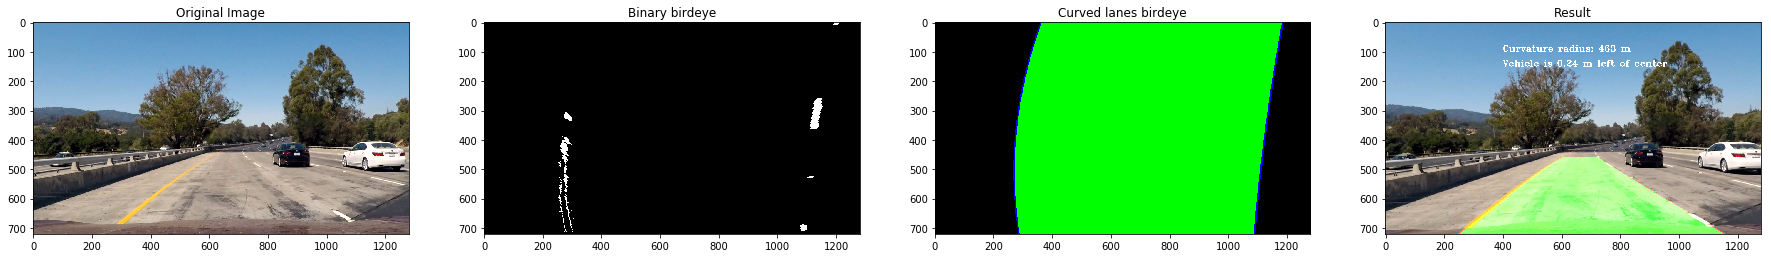

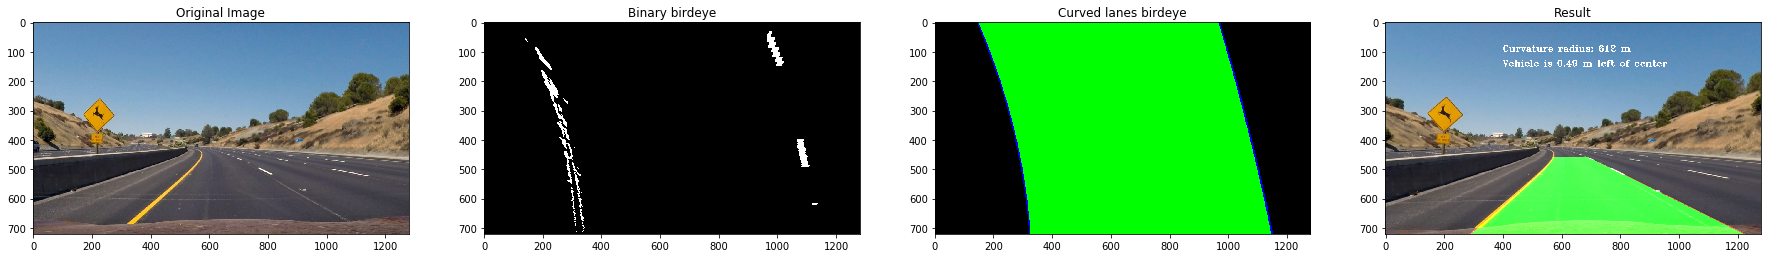

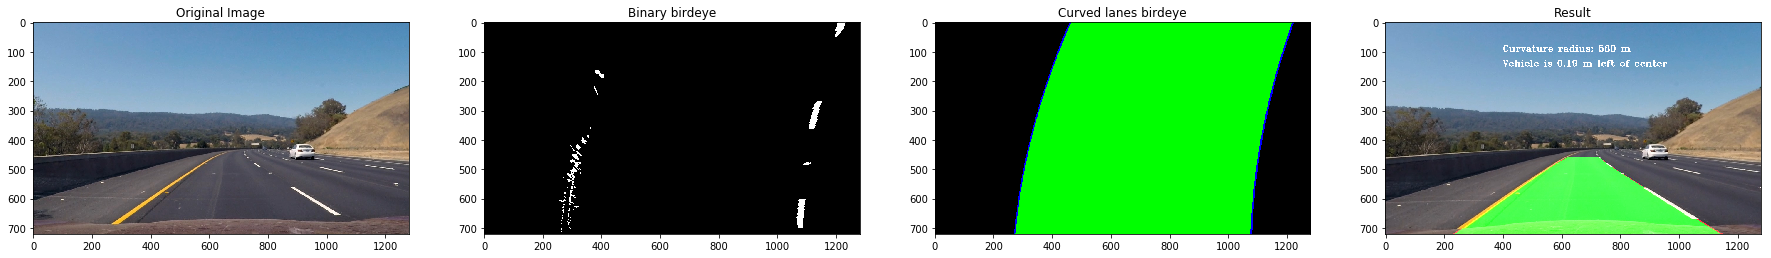

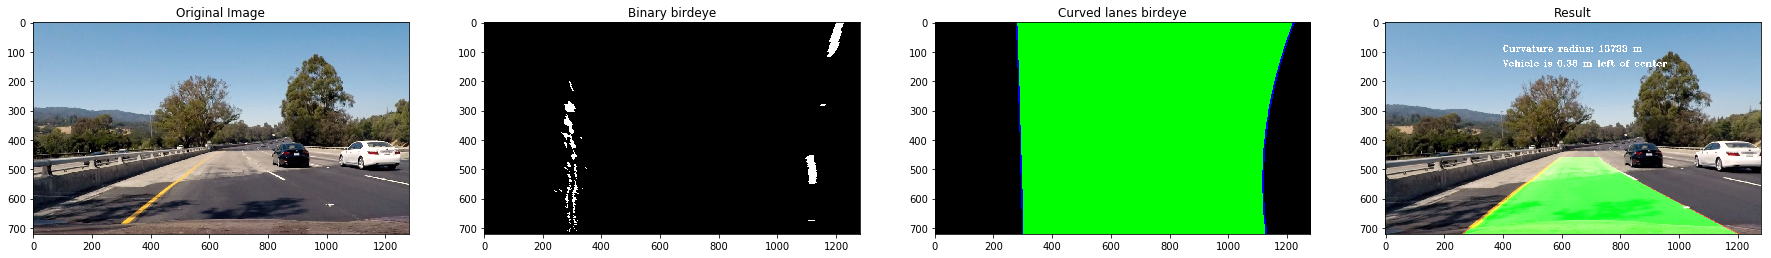

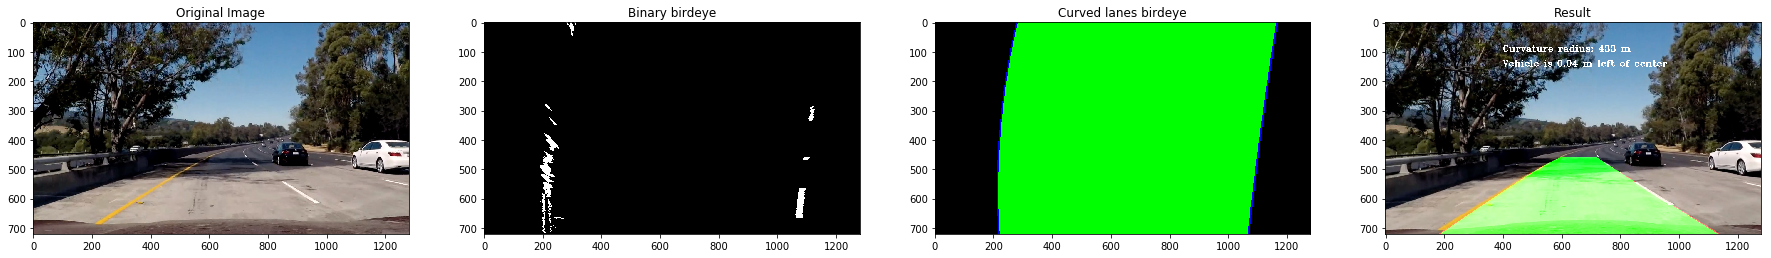

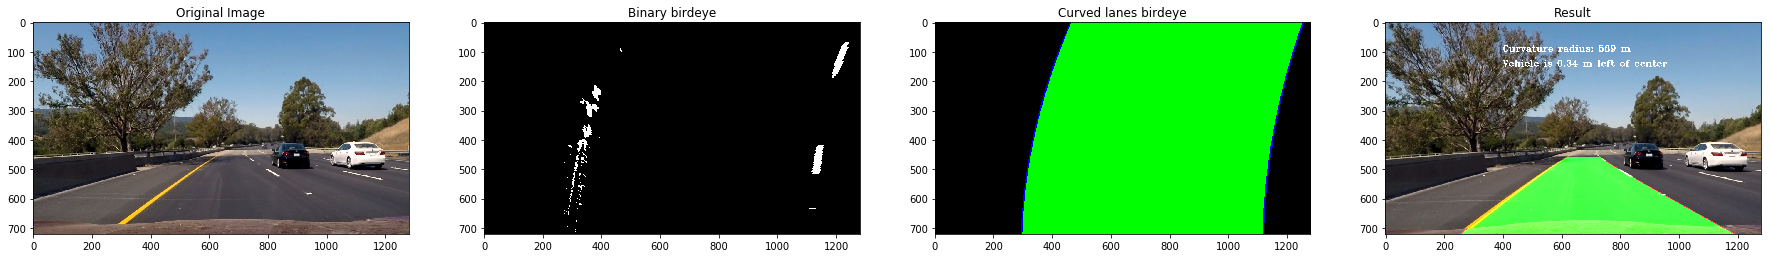

In [12]:
BGR = True
for i in range(1,7):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    # Set up lines for left and right
    left_lane, right_lane = Line(), Line() 
    result = pipeline(image)
    test_img_undst = cv2.undistort(image, mtx, dist, None, mtx)
    cv2.imwrite('output_images/test{}_0_undist.jpg'.format(i), test_img_undst)
    birdeye, M, M_inv = get_binary_birdeye_v2(test_img_undst)
    birdeye_to_be_saved = (birdeye*255).astype('uint8')
    cv2.imwrite('output_images/test{}_1_birdeye.jpg'.format(i), birdeye_to_be_saved)
    highlited_lane, left_fit, right_fit, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, l_rad, r_rad = detect_and_highlight_lane(birdeye)
    cv2.imwrite('output_images/test{}_2_warped_highlighted.jpg'.format(i), highlited_lane)
    combined_img = undistort_and_apply_figures(test_img_undst,highlited_lane,M_inv, l_rad)
    cv2.imwrite('output_images/test{}_3_final.jpg'.format(i), combined_img)
    # Plot the result
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(24, 9))
    ax1.imshow(image[...,::-1])
    ax1.set_title('Original Image')
    
    ax2.imshow(birdeye,cmap='gray')
    ax2.set_title('Binary birdeye')
    """
    ax2.imshow(testMask,cmap='gray')
    ax2.set_title('testamaska')"""
    ax3.imshow(highlited_lane)
    ax3.set_title('Curved lanes birdeye')
    ax4.imshow(result[...,::-1])
    ax4.set_title('Result')
    
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Pipeline on project video

In [13]:
BGR = False;
### Import everything needed to edit/save/watch video clips
app_left, app_right = None, None
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line() 
white_output = 'project_video_result_v2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_result_v2.mp4
[MoviePy] Writing video project_video_result_v2.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [11:42<00:00,  1.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result_v2.mp4 

Wall time: 11min 47s
